In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3, CP_L3_sparse, NCP_L3, CP, Chebyshev, Chebyshev_L3
import polynomial_nets as pn
import poly_utils as ut 

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, VAE_CP_L3_sparse, VAE_CP_L3_sparse_LU, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

import uqtestfuns as uqtf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from Cuda import DeviceDataLoader

/home/ashish-razer/Programs/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CP_L3(nn.Module):
    def __init__(self, d, k, o):
        super(CP_L3, self).__init__()
        
        self.layer_U1 = nn.Linear(d, k, bias=False)
        self.layer_U2 = nn.Linear(d, k, bias=False)
        self.layer_U3 = nn.Linear(d, k, bias=False)
        self.layer_C = nn.Linear(k, o)   
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        x1 = self.layer_U1(z)
        x2 = self.layer_U2(z) * x1 + x1 
        x3 = self.layer_U3(z) * x2 + x2 
        x = self.layer_C(x3)
        return x

In [3]:
class CP_L3_shared(nn.Module):
    def __init__(self, d, k, o):
        super(CP_L3_shared, self).__init__()
        
        self.layer_U1 = nn.Linear(d, k, bias=False)
        #self.layer_U2 = nn.Linear(d, k, bias=False)
        #self.layer_U3 = nn.Linear(d, k, bias=False)
        self.layer_C = nn.Linear(k, o)   
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        x1 = self.layer_U1(z)
        x2 = self.layer_U1(z) * x1 + x1 
        x3 = self.layer_U1(z) * x2 + x2 
        x = self.layer_C(x3)
        return x

In [4]:
class CP_L3_shared2(nn.Module):
    def __init__(self, d, k, o):
        super(CP_L3_shared2, self).__init__()
        
        self.layer_U1 = nn.Linear(d, k, bias=False)
        #self.layer_U2 = nn.Linear(d, k, bias=False)
        #self.layer_U3 = nn.Linear(d, k, bias=False)
        self.layer_C = nn.Linear(k, o)   
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        x1 = self.layer_U1(z)
        x2 = self.layer_U1(z) * x1 
        x3 = self.layer_U1(z) * x2 
        x = self.layer_C(x3)
        return x

In [5]:
class CP_shared(nn.Module):
    def __init__(self, degree, d, k, o):
        super(CP_shared, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.layer_U1 = nn.Linear(self.input_dimension, self.rank, bias=False)
        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out = self.layer_U1(z)
        for i in range(1, self.degree):
            out = self.layer_U1(z) * out + out
        x = self.layer_C(out)
        return x

In [6]:
my_testfun =  uqtf.Borehole()
N = 10000
train = 0.9
N_t = int(N * train)
N_v = N - N_t

In [7]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
NUM_EPOCHS = 5
RANK = 15
DEGREE = 6
IN_DIM = my_testfun.spatial_dimension
OUT_DIM = 1

loss_fn = nn.MSELoss()

In [8]:
np.random.seed(42)
dataset, target_scaler = ut.generate_dataset_uqtf(my_testfun, N, MinMaxScaler())
train_ds, val_ds = random_split(dataset, [N_t, N_v])
train_loader = DeviceDataLoader(DataLoader(train_ds, BATCH_SIZE, shuffle=True), device)
val_loader = DeviceDataLoader(DataLoader(val_ds, BATCH_SIZE), device)

In [9]:
model = CP_L3_shared(IN_DIM, RANK, OUT_DIM)
model = CP_shared(DEGREE, IN_DIM, RANK, OUT_DIM)
#model = CP_L3(IN_DIM, RANK, OUT_DIM)
optimizer = torch.optim.Rprop

CP_reg = ut.Regression(model, IN_DIM, loss_fn).to(device)

In [10]:
history, losses = ut.fit(NUM_EPOCHS, LEARNING_RATE, CP_reg, train_loader, val_loader, opt_func=optimizer)

AttributeError: 'CP_shared' object has no attribute 'U1'

In [ ]:
CP_reg.to('cpu')

Regression(
  (model): CP_L3_shared(
    (layer_U1): Linear(in_features=8, out_features=15, bias=False)
    (layer_C): Linear(in_features=15, out_features=1, bias=True)
  )
  (loss_function): MSELoss()
)

In [ ]:
np.random.seed(44)
test_dataset, target_scaler_test = ut.generate_dataset_uqtf(my_testfun, N, MinMaxScaler())
test_target = test_dataset[:, IN_DIM:].to('cpu')
test_input = test_dataset[:, :IN_DIM].to('cpu')
test_target_scaled = target_scaler.inverse_transform(test_target)

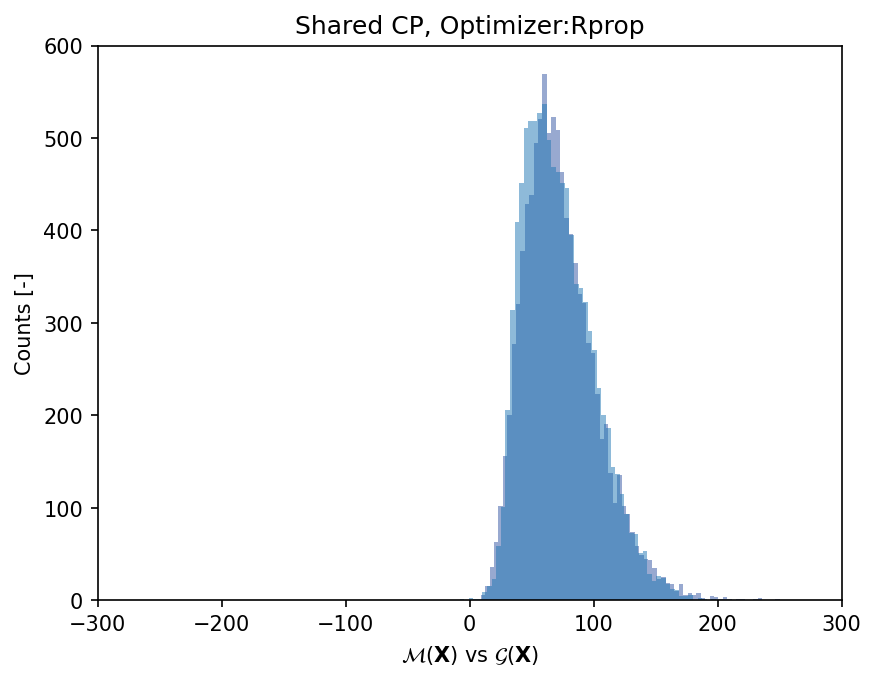

In [ ]:
model_name = ['Shared CP']
Optimizer_name = ['Rprop']

outputs = CP_reg(test_input).to('cpu')
outputs = target_scaler.inverse_transform(outputs.reshape(-1,1).detach().numpy())
test_target = test_target_scaled



fig1 = plt.figure()
plt.hist(test_target_scaled, bins="auto", color="#8da0cb", alpha = 0.9)
plt.hist(outputs, bins='auto', alpha = 0.5)
plt.xlim(-300, 300)
plt.ylim(0, 600)
plt.title(model_name[0] +', Optimizer:'+ Optimizer_name[0])
#plt.title(Optimizer_name[j])
plt.xlabel("$\mathcal{M}(\mathbf{X})$ vs $\mathcal{G}(\mathbf{X})$")
plt.ylabel("Counts [-]")
plt.gcf().set_dpi(150);

In [ ]:
np.random.seed(44)


outputs = CP_reg(test_dataset[:, :IN_DIM].to('cpu')).to('cpu').detach().numpy()
outputs = torch.tensor(target_scaler.inverse_transform(outputs)) 
test_target = test_dataset[:, IN_DIM:].to('cpu').detach().numpy()
test_target = torch.tensor(target_scaler.inverse_transform(test_target) )
mse = loss_fn(outputs, test_target).detach().item()


l_inf = torch.max(abs(outputs-test_target)).item()


In [ ]:
print(mse, l_inf)

110.76985931396484 92.30061340332031


In [ ]:
U1_weight = CP_reg.model.layer_U1.weight.to(torch.float64)

In [ ]:
torch.min(abs(U1_weight))

tensor(0.0004, dtype=torch.float64, grad_fn=<MinBackward1>)

In [ ]:
num_param =  ut.non_zero_count(CP_reg)

In [ ]:
num_param

tensor(136)

In [ ]:
#sparse_cheby = ut.sparse_model(copy.deepcopy(Cheby_reg), 0.2)
sparse_params_CP = ut.params_CP(model, k, d)
mi_list_CP = ut.multi_indices_list_CP(sparse_params_CP)
mi_net_CP = ut.multi_indices_net_CP(mi_list_CP)

NameError: name 'k' is not defined

In [ ]:
len(mi_net_CP)

184755

In [ ]:
mi_sum = mi_net_CP.sum(axis=1)
mi_sum_0  = mi_net_CP.sum(axis=0)

In [ ]:

z = torch.randn(2, 3)

In [ ]:
z

tensor([[-0.7503,  0.2244,  0.6072],
        [ 0.9330, -0.3407, -1.8187]])

In [ ]:
#z.repeat_interleave()

In [ ]:
U1 = nn.Linear(d, k, bias=False)

In [ ]:
U1.weight

Parameter containing:
tensor([[-0.1630, -0.2370,  0.1164,  0.2408,  0.2632,  0.1538,  0.1005, -0.0034,
         -0.0961,  0.2502]], requires_grad=True)

In [ ]:
x1 = U1(z)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x3 and 10x1)

In [ ]:
x1

tensor([[-0.0564],
        [ 0.4185]], grad_fn=<MmBackward0>)

In [ ]:
mult_identity = torch.ones_like(U1.weight)

In [ ]:
x1_1 = torch.matmul(z, mult_identity.T)

In [ ]:
x1_1 = U1(z)

In [ ]:
x1_1

tensor([[-0.0564],
        [ 0.4185]], grad_fn=<MmBackward0>)

In [ ]:
x2 = x1 * x1_1

In [ ]:
x3 = x2 * x1_1

In [ ]:
x3

tensor([[-0.0002],
        [ 0.0733]], grad_fn=<MulBackward0>)